In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
!pip3 install chart-studio
import chart_studio.plotly as py

# hide warnings
import warnings
warnings.simplefilter("ignore")

# checking if plotly is installed; install otherwise
try:
    import plotly.plotly as py
except:
    ! pip install --user plotly
    #import plotly.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# checking if seaborn is installed; install otherwise
try:
    import seaborn as sns
except:
    ! pip install --user seaborn
    import seaborn as sns

In [2]:
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

# Convert the first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# Set the first column (dt) as the index column
df.index = df['dt']
del df['dt']

# Dropping AverageTemperatureUncertainty, Latitude, and Longitude
df = df.drop(["AverageTemperatureUncertainty", "Latitude", "Longitude"], axis=1)

# Combining City and Country into City
df["City"] = df["City"] + ", " + df["Country"]

# Dropping the Country column
df = df.drop("Country", axis=1)

# Removing all rows with NaN values
df = df.dropna()

# Get a list of all cities in the dataset
cities = set(df.City)

# Now you have a DataFrame 'df' with the desired modifications, and 'cities' contains a set of unique city names.


In [3]:
def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    city_df.plot(figsize=(10, 10))

    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    city_df.hist(figsize=(10, 10))
    plt.show()

    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")

    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")

    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [4]:
city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=2117, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', '…

In [5]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop(columns="City")


Stationarity Check for New York, United States


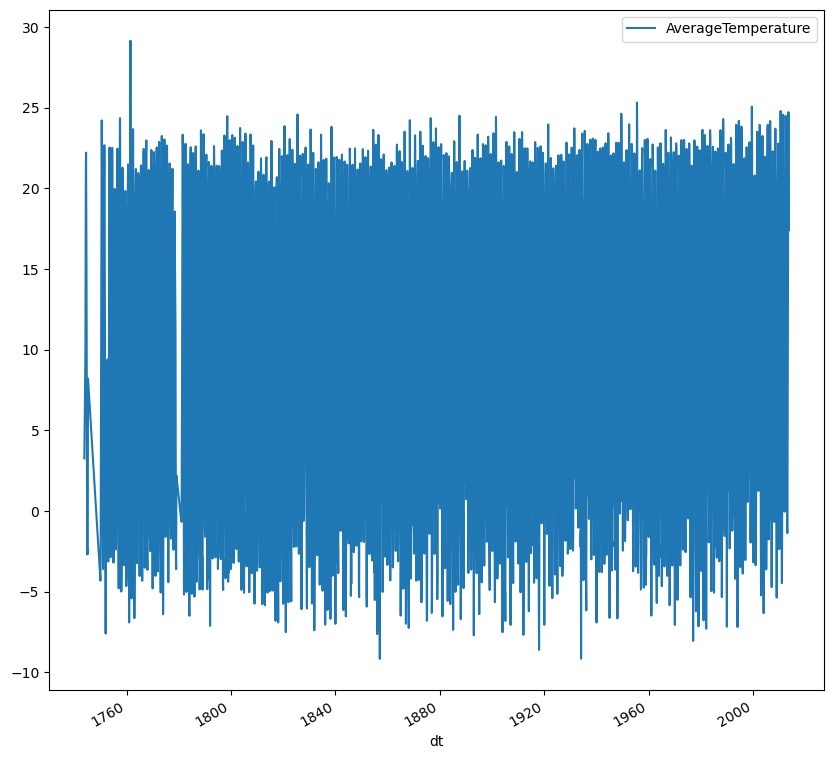

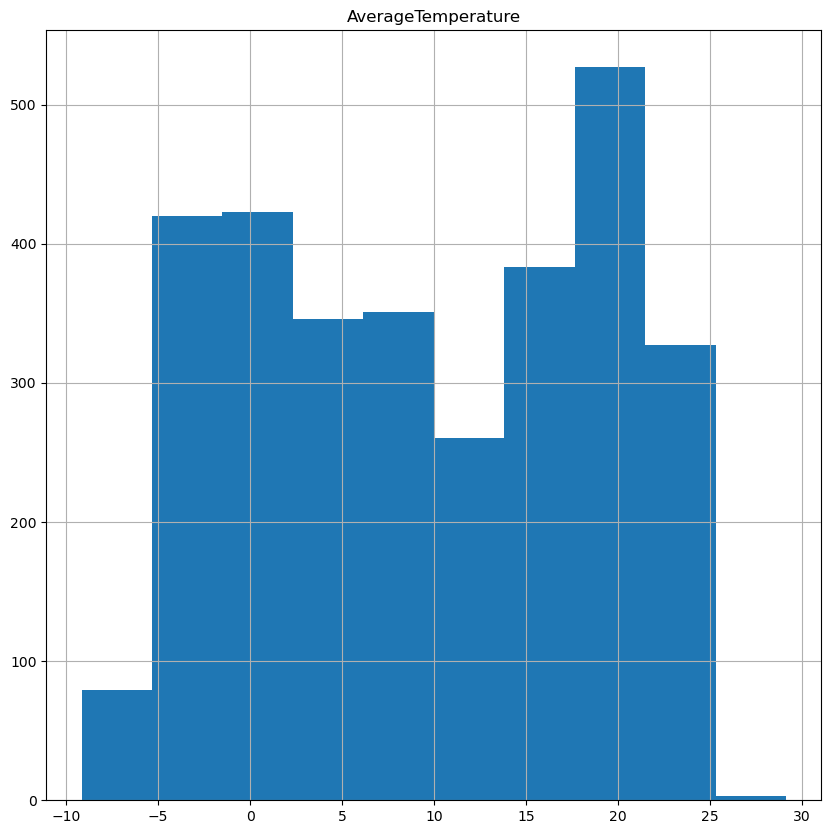

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [6]:

print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

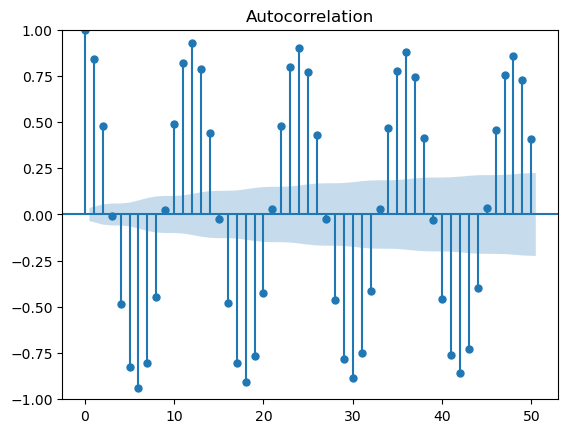

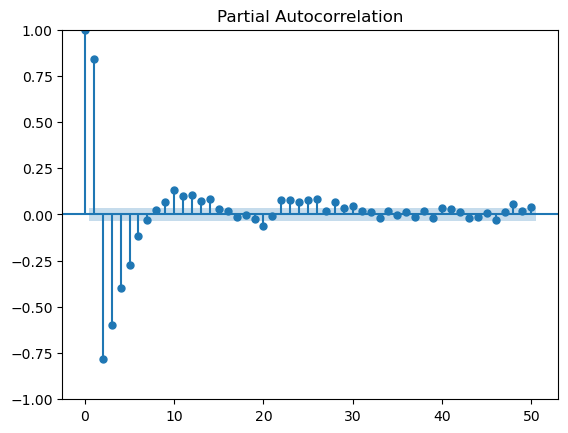

In [7]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [8]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
# To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

best_aic = float("inf")
best_pq = (0, 0)

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit()
            aic = results.aic
            bic = results.bic
            aic_values.append(aic)
            bic_values.append(bic)
            pq_values.append((p, q))

            # Update best (p, q) if the current model has a lower AIC
            if aic < best_aic:
                best_aic = aic
                best_pq = (p, q)

        except Exception as e:
            print(f"Error for (p, q) = ({p}, {q}): {str(e)}")

print("Best (p, q) corresponding to lowest AIC score:", best_pq)

Best (p, q) corresponding to lowest AIC score: (2, 2)


In [9]:
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.678029980480845
Mean Absolute Error: 1.5779962522050597


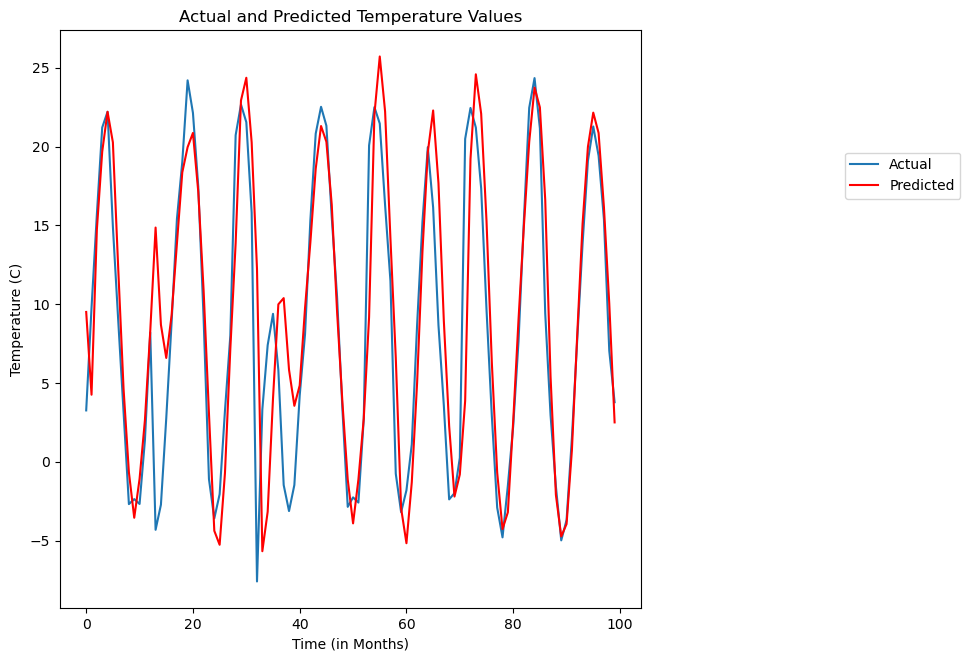

In [10]:
plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [11]:
years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [12]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)  # predictions

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  # excluding predictions for remaining months in current year


In [13]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  2.1457325088245502 C
February:  4.258318869340164 C
March:  7.765611209320609 C
April:  11.707598629120195 C
May:  15.016809794118114 C
June:  16.807274771795626 C
July:  16.611601404478236 C
August:  14.502760783795093 C
September:  11.068912259449602 C
October:  7.249551904870497 C
November:  4.078581487525684 C
December:  2.404532248744074 C


In [14]:
trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

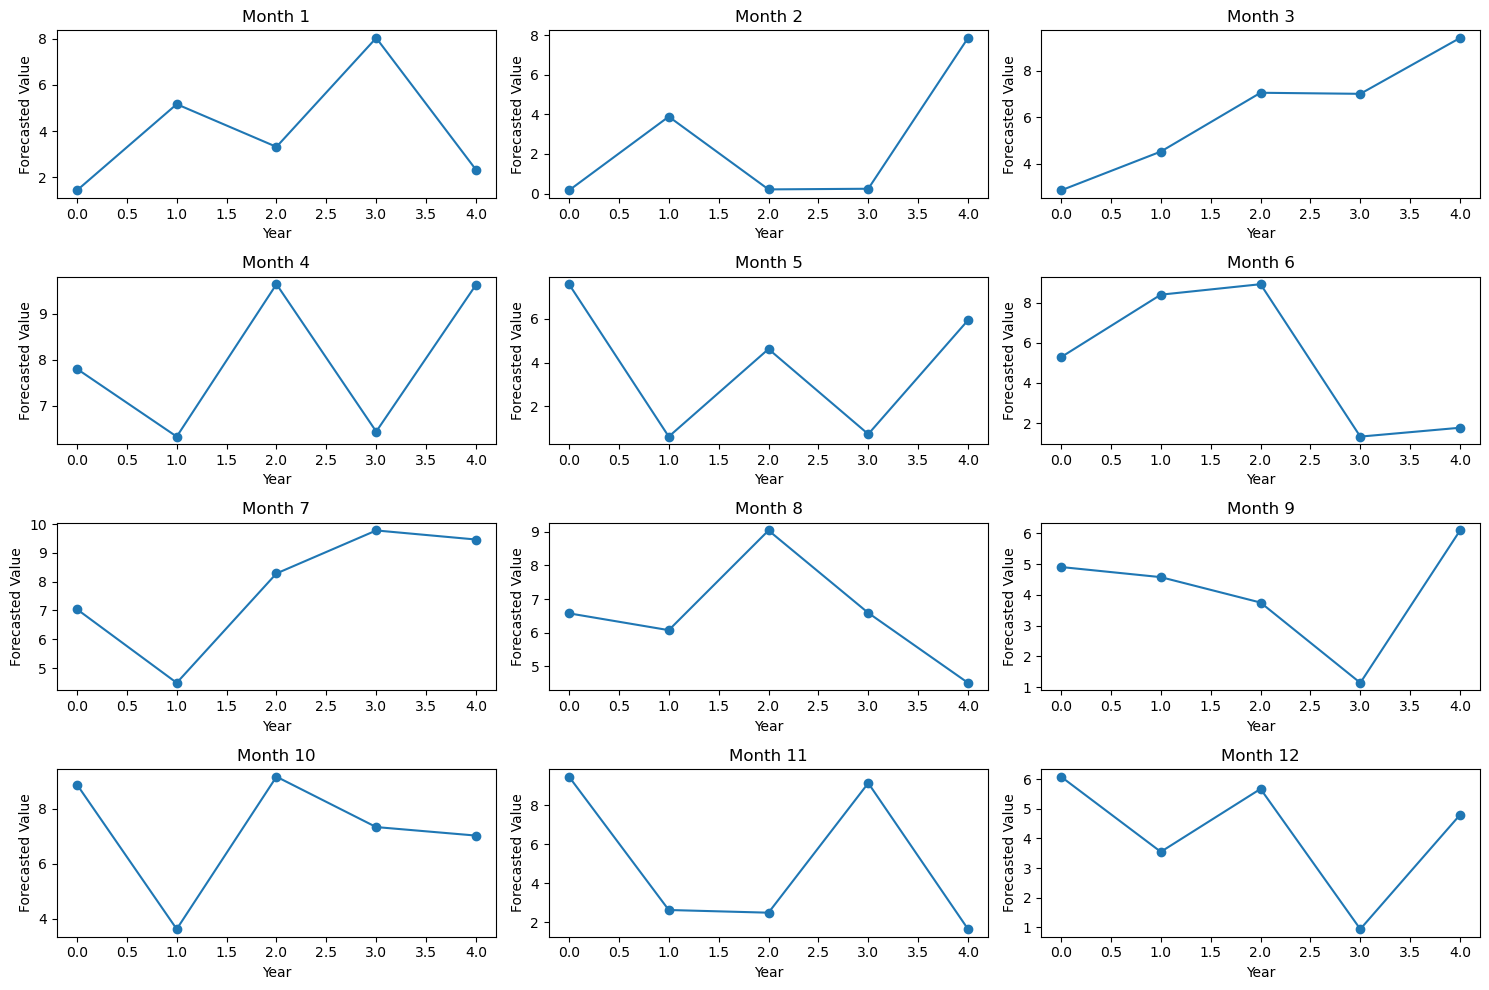

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots with 4 rows and 3 columns
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))

# Example data (replace this with your actual data)
num_years = 5  # Number of years
monthly_change = {}  # Replace with your dictionary of monthly forecasted values

# Iterate through the 12 months for plotting
for month in range(12):
    row = month // 3  # Calculate the row index
    col = month % 3   # Calculate the column index

    # Extract the forecasted values for the current month (month) across all years
    # Example: monthly_values = monthly_change[month]
    # Replace this with the actual code to access your forecasted values

    # Example data (replace this with your actual data)
    monthly_values = np.random.rand(num_years) * 10  # Replace with actual values

    # Plot the monthly changes for the current month
    ax[row, col].plot(range(num_years), monthly_values, marker='o', linestyle='-')
    ax[row, col].set_title(f'Month {month + 1}')
    ax[row, col].set_xlabel('Year')
    ax[row, col].set_ylabel('Forecasted Value')

# Adjust layout
plt.tight_layout()

# Optionally, save the plot as an image file
# plt.savefig('monthly_changes.png', dpi=300)

plt.show()


In [16]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

# Convert the first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# Set the first column (dt) as the index column
df.index = df['dt']
del df['dt']

# Drop the AverageTemperatureUncertainty column
df = df.drop("AverageTemperatureUncertainty", axis=1)

# Drop any rows with missing values
df = df.dropna()

# While estimating top 10 US cities using the whole data, we got multiple cities with identical latitude and longitude values, making plotting difficult
# Therefore, we only consider US cities with unique latitude and longitude values

# Getting the first city for each unique latitude-longitude pair
new_us_cities_df = df[df['Country'] == 'United States'].drop(['Country'], axis=1)
new_us_cities_df['latlon'] = new_us_cities_df['Latitude'] + ', ' + new_us_cities_df['Longitude']
new_us_cities_df = new_us_cities_df.sort_values('latlon')

unique_latlon_values = set(list(new_us_cities_df.latlon))
cities = list(new_us_cities_df.City)

unique_latlon_first_cities = []

for x in unique_latlon_values:
    i = list(new_us_cities_df.latlon).index(x)
    unique_latlon_first_cities.append(cities[i])

part_2_df = df[df['City'].isin(unique_latlon_first_cities)].drop(['Country', 'Latitude', 'Longitude'], axis=1)
part_2_df.head()


,AverageTemperature,City
dt,,
1820-01-01,2.101,Abilene
1820-02-01,6.926,Abilene
1820-03-01,10.767,Abilene
1820-04-01,17.989,Abilene
1820-05-01,21.809,Abilene


In [17]:
warnings.simplefilter("ignore")

changes = []  # stores temperature change for cities
avg_2013 = []  # stores average of 2013 temperature for each city
avg_2023 = []  # stores average of 2023 temperature for each city

for each_city in set(unique_latlon_first_cities):
    new_city_df = part_2_df[part_2_df.City == each_city].drop("City", axis=1)
    new_city_df_mean = new_city_df.resample("A").mean()  # stores yearly mean temperature values for city
    new_city_df_mean = new_city_df_mean.dropna()
    last_year_average = new_city_df_mean['AverageTemperature'][-1]  # average of last year temperature for comparison later
    avg_2013.append(last_year_average)

    # Making predictions for the city for the next 10 years
    p_range = q_range = [i for i in range(0, 3)]  # taking values from 0 to 2
    best_pq = (0, 0)
    best_aic = float('inf')  # Initialize with a large value

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(new_city_df, order=(p, d, q))
                #results = model.fit()
                aic = results.aic
                bic = results.bic
                aic_values.append(aic)
                bic_values.append(bic)
                pq_values.append((p, q))

                # Update best (p, q) if the current model has a lower AIC
                if aic < best_aic:
                    best_aic = aic
                    best_pq = (p, q)

            except Exception as e:
                print(f"Error for (p, q) = ({p}, {q}): {str(e)}")

    # ARIMA model for the city with the best (p, q)
    arima_model = ARIMA(new_city_df, order=(best_pq[0], d, best_pq[1])).fit()

    # Make prediction for next 10 years using 120 steps
    out_of_sample_forecast = arima_model.forecast(steps=120)
    average_after_10_years = np.mean(out_of_sample_forecast[-9:])  # Average of 10th year's values (after 10 years)
    avg_2023.append(average_after_10_years)

    changes.append(abs(last_year_average - average_after_10_years))

# Find the top 10 cities with the largest temperature changes
top_10_changes_indices = sorted(range(len(changes)), key=lambda i: changes[i], reverse=True)[:10]
top_10_cities = [unique_latlon_first_cities[x] for x in top_10_changes_indices]

# Print the top 10 cities and their temperature changes
for i, city in enumerate(top_10_cities):
    print(f"{i+1}. {city}: Temperature Change = {changes[top_10_changes_indices[i]]}°C")

# You can also access the average temperatures for 2013 and 2023 using 'avg_2013' and 'avg_2023' lists.


1. Beaumont: Temperature Change = 3.461031969788282°C
2. Columbia: Temperature Change = 3.344121138523631°C
3. Austin: Temperature Change = 3.327362764332353°C
4. Cape Coral: Temperature Change = 3.3204010410271483°C
5. Minneapolis: Temperature Change = 3.0830237804396603°C
6. Des Moines: Temperature Change = 3.0342303131651907°C
7. Pembroke Pines: Temperature Change = 2.8579795462729436°C
8. Philadelphia: Temperature Change = 2.809579590127715°C
9. Greensboro: Temperature Change = 2.715188107781975°C
10. Corpus Christi: Temperature Change = 2.6937500030948485°C


In [18]:
# plotting the top-10 cities using plotly

top10_df = pd.DataFrame()
top10_df['city'] = top_10_cities
top10_df['latitude'] = [new_us_cities_df.Latitude[new_us_cities_df.City==x][-1] for x in top_10_cities]
top10_df['longitude'] = [new_us_cities_df.Longitude[new_us_cities_df.City==x][-1] for x in top_10_cities]
top10_df['2013_average'] = [avg_2013[x] for x in top_10_changes_indices]
top10_df['2023_average'] = [avg_2023[x] for x in top_10_changes_indices]
top10_df['change'] =  [changes[x] for x in top_10_changes_indices]
top10_df = top10_df.round({'2013_average':2, '2023_average':2, 'change':2})
top10_df['text'] = top10_df['city'] + ', Avg. Temperature in 2013: ' + top10_df['2013_average'].astype(str) + 'C, Avg. Temperature in 2023: ' + top10_df['2023_average'].astype(str) +'C'

# convert latitude and longitude to numeric values for plotting i.e. remove 'N' and 'W' from values and also make longitudes negative
top10_df['latitude'] = [float(x[:-1]) for x in list(top10_df['latitude'])]
top10_df['longitude'] = [-float(x[:-1]) for x in list(top10_df['longitude'])]

scl = [ [0,"rgb(172, 5, 5)"],[0.35,"rgb(190, 40, 40)"],[0.5,"rgb(245, 70, 70)"],[0.6,"rgb(245, 89, 89)"],[0.7,"rgb(247, 106, 106)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = top10_df['longitude'],
        lat = top10_df['latitude'],
        text = top10_df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = top10_df['change'],
            cmax = top10_df['change'].max(),
            colorbar=dict(
                title="Temperature Change"
            )
        ))]

layout = dict(
        title = 'Top 10 Cities with most Temperature Change in 10 Years<br><i>Hover for Details</i>',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=data, layout=layout)
iplot(fig, validate=False, filename='top-10-cities')

In [26]:
import statsmodels.api as sm
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")
df['dt'] = pd.to_datetime(df['dt'])
df.index = df['dt']
del df['dt']
df = df.drop({"AverageTemperatureUncertainty"}, axis=1)
df = df.dropna()

# Get the list of unique countries
unique_countries = df['Country'].unique()

# Create a dropdown widget for selecting a country
country_dropdown = widgets.Dropdown(
    options=unique_countries,
    description='Select a Country:',
)

# Function to update the city dropdown based on the selected country
def update_city_dropdown(change):
    selected_country = change.new
    cities_in_country = df[df['Country'] == selected_country]['City'].unique()
    city_dropdown.options = cities_in_country

country_dropdown.observe(update_city_dropdown, names='value')

# Create a dropdown widget for selecting a city
city_dropdown = widgets.Dropdown(
    options=df[df['Country'] == country_dropdown.value]['City'].unique(),
    description='Select a City:',
)

# Create an input widget for specifying the prediction year
prediction_year = widgets.BoundedIntText(
    value=2023,
    min=1950,
    max=2100,
    step=1,
    description='Enter the Prediction Year:',
)

# Function to make predictions for the selected city and year
# Function to make predictions for the selected city and year
def make_predictions(country, city, year):
    selected_city_df = df[(df['Country'] == country) & (df['City'] == city)].drop(['Country', 'City'], axis=1)
    selected_city_df['AverageTemperature'] = pd.to_numeric(selected_city_df['AverageTemperature'], errors='coerce')

    # Check stationarity and determine the 'd' value (as per your previous code)
    d = 0  # Replace with your 'd' value

    # Fit an ARIMA model
    p_range = q_range = list(range(0, 3))
    aic_values = []
    best_pq = (0, 0)
    best_aic = float("inf")

    for p in p_range:
        for q in q_range:
            try:
                model = sm.tsa.ARIMA(selected_city_df['AverageTemperature'], order=(p, d, q))
                results = model.fit()
                aic = results.aic

                # Update best (p, q) if the current model has a lower AIC
                if aic < best_aic:
                    best_aic = aic
                    best_pq = (p, q)
            except Exception as e:
                print(f"Error for (p, q) = ({p}, {q}): {str(e)}")

    arima_model = sm.tsa.ARIMA(selected_city_df['AverageTemperature'], order=(best_pq[0], d, best_pq[1])).fit()

    # Generate predictions for each month of the selected year
    predictions = []

    for month in range(1, 13):
        number_of_steps = (year - 2018) * 12 + month - 1
        out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)
        prediction_for_month = out_of_sample_forecast.iloc[-1]
        predictions.append((f"{year}-{month:02d}", prediction_for_month))

    print("Predicted average temperatures for the year", year, ":")
    for month, prediction in predictions:
        print(f"{month} : {prediction:.2f}°C")

# Create a button to trigger predictions
predict_button = widgets.Button(
    description='Predict',
)

# Function to handle button click
def on_predict_button_clicked(b):
    make_predictions(country_dropdown.value, city_dropdown.value, prediction_year.value)

predict_button.on_click(on_predict_button_clicked)

# Display the widgets
display(country_dropdown)
display(city_dropdown)
display(prediction_year)
display(predict_button)

Dropdown(description='Select a Country:', options=('Denmark', 'Turkey', 'Kazakhstan', 'China', 'Spain', 'Germa…

Dropdown(description='Select a City:', options=('Århus', 'Aalborg', 'Copenhagen', 'Odense'), value='Århus')

BoundedIntText(value=2023, description='Enter the Prediction Year:', max=2100, min=1950)

Button(description='Predict', style=ButtonStyle())

Predicted average temperatures for the year 2028 :
2028-01 : 13.13°C
2028-02 : 7.83°C
2028-03 : 0.59°C
2028-04 : -6.66°C
2028-05 : -11.97°C
2028-06 : -13.95°C
2028-07 : -12.07°C
2028-08 : -6.84°C
2028-09 : 0.32°C
2028-10 : 7.50°C
2028-11 : 12.79°C
2028-12 : 14.78°C


In [20]:
df = pd.read_csv("GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"},1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()

In [28]:
gg_df = pd.read_csv("greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)

# getting yearly emissions for the 4 major greenhouse gases i.e. CO2, Methane, Nitrous Oxide and HCFCs
df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']

In [27]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,16.975
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,15.788
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.337
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,6.990
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,5.722


In [23]:
part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [24]:
trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)


layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

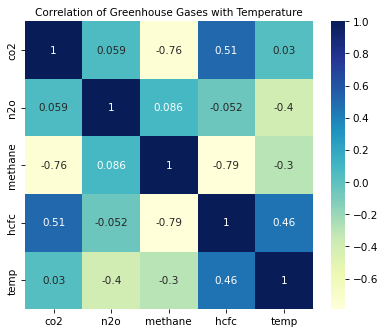

In [25]:
fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature", fontsize=10)
plt.show()